In [40]:
import urllib.request
import os
import shutil
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import random
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, Binarizer
from sklearn.impute import SimpleImputer

## Zapoznanie się z zestawami danych


### MNIST

http://yann.lecun.com/exdb/mnist/


MNIST (Modified National Institute of Standards and Technology database) - duży zbiór ręcznie zapisanych cyfr. Zawiera znormalizowane obrazki (28x28 px, anti-alliasing). 
Posiada 60'000 obrazów treningowych i 10'000 testowych.


Musimy zacząć od pobrania i zdekowania danych. Można zrobic to np. na piechotę:

In [3]:
mnist_prefix = "./mnist"
shutil.rmtree(mnist_prefix)
os.mkdir(mnist_prefix)
base_url = "http://yann.lecun.com/exdb/mnist/"
datasets = ["train-labels-idx1-ubyte.gz", "train-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz"]

In [11]:
def fetch_gz(base_url, name):
    path = "{}/{}".format(mnist_prefix, name)
    urllib.request.urlretrieve("{}{}".format(base_url, name), path)
    data_file = gzip.open(path, "rb")
    data = data_file.read()
    data_file.close()
    return data

In [5]:
def decode_mnist(data):
    magic_number = int.from_bytes(data[0:4], byteorder='big')
    if magic_number == 2051:
        number_of_images = int.from_bytes(data[4:8], byteorder='big')
        rows = int.from_bytes(data[8:12], byteorder='big')
        columns = int.from_bytes(data[12:16], byteorder='big')
        print("File contains {} images {}x{}".format(number_of_images, rows, columns))
        pixels = [int(b) for b in data[16:]]
        return np.array(pixels).reshape((number_of_images, rows, columns))
    elif magic_number == 2049:
        number_of_labels = int.from_bytes(data[4:8], byteorder='big')
        print("File contain {} labels".format(number_of_labels))
        return [int(b) for b in data[8:]]

In [12]:
(train_labels, train_images, test_labels, test_images) = [decode_mnist(fetch_gz(base_url, ds)) for ds in datasets]

File contain 60000 labels
File contains 60000 images 28x28
File contain 10000 labels
File contains 10000 images 28x28


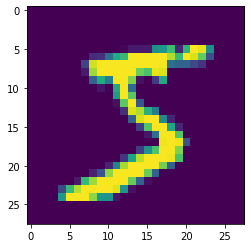

In [37]:
plt.imshow(train_images[0])

In [39]:
train_labels[0]

5

Lub w bardziej cywilizowany sposób używając gotowych funkcji bibliotek i pobierając dane np. z openml (https://www.openml.org/search?type=data):

In [5]:
mnist = fetch_openml("mnist_784")

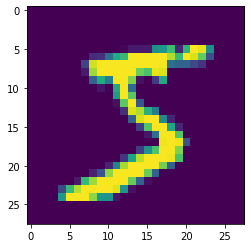

In [9]:
plt.imshow(np.array(mnist.data[0]).reshape(28,28))

### Fashion-MNIST

Fashion-MNIST

Zbiór analogiczny do MNIST, zawiera obrazy przedstawiające elementy odzieży. 70'000 obrazów 28x28 px w skali szarości. Wskazywany jako następca MNIST ( MNIST jest uznawany za zbyt prosty, zbyt często używany, FMNIST lepiej oddaje współczesne problemy Computer Vision).


https://github.com/zalandoresearch/fashion-mnist

In [3]:
fmnist = fetch_openml("Fashion-MNIST")

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

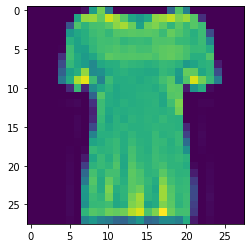

In [29]:
print(fmnist.DESCR)

plt.imshow(np.array(fmnist.data[10]).reshape(28,28))
print('Category:', fmnist.target[10])

### CIFAR-10
https://www.cs.toronto.edu/~kriz/cifar.html

In [27]:
cifar10 = fetch_openml("CIFAR_10")

**Author**: Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton    
**Source**: [University of Toronto](https://www.cs.toronto.edu/~kriz/cifar.html) - 2009  
**Please cite**: Alex Krizhevsky (2009) Learning Multiple Layers of Features from Tiny Images, Tech Report.

**CIFAR-10** is a labeled subset of the [80 million tiny images dataset](http://groups.csail.mit.edu/vision/TinyImages/). It (originally) consists 32x32 color images representing 10 classes of objects:  
0. airplane  
1. automobile          
2. bird          
3. cat          
4. deer          
5. dog          
6. frog          
7. horse          
8. ship          
9. truck          

CIFAR-10 contains 6000 images per class. The original train-test split randomly divided these into 5000 train and 1000 test images per class.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes

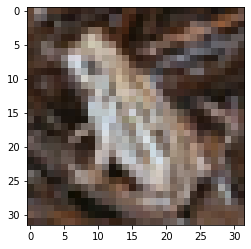

In [37]:
print(cifar10.DESCR)

single_img_reshaped = np.transpose(np.array(cifar10.data[623]).reshape(3,32,32).astype(int) , (1,2,0))
plt.imshow(single_img_reshaped)

### SmallNorb

https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/

### TNG
https://github.com/RMHogervorst/TNG

TODO: Poprosić profesora o dostarczenie datasetu w formie wektorów.

## Procedury normalizujące dane i wybierające dane ze zbioru danych

TODO: opis procedur

### Wybieranie danych

Najprostszy sposób na zmniejszenie rozmiaru datasetu - wzięcie n początkowych elementów:


In [60]:
fmnist_zipped = zip(fmnist.data, fmnist.target)
fmnist_reduced_list = list(fmnist_zipped)[:1000]

fmnist_reduced_data, fmnist_reduced_target = zip(*(fmnist_reduced_list))
print((list(fmnist_reduced_target)[0:10]))


['9', '0', '0', '3', '0', '2', '7', '2', '5', '5']


Wzięcie _n_ losowych elementów z datasetu (bez modyfikacji kolejności w źródłowym datasecie):

In [61]:
fmnist_random_sample = random.sample(fmnist_reduced_list, 100)
fmnist_reduced_data, fmnist_reduced_target = zip(*(fmnist_random_sample))
print((list(fmnist_reduced_target)[0:10]))

['5', '4', '7', '7', '3', '6', '1', '4', '1', '6']


Podział danych na zbiór testowy oraz treningowy przy pomocy _sklearn_ :

In [65]:
X = fmnist.data
y = fmnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train: ', len(X_train), ' y_train: ', len(y_train))
print('X_test: ', len(X_test), ' y_test: ', len(y_test))

X_train:  56000  y_train:  56000
X_test:  14000  y_test:  14000


### Normalizacja danych

TODO: Opisać bardziej poszczególne metody normalizacji i standaryzacji, dodać przykład ze zdjęciem

Normalizację danych wykonamy na danych UCI "Communities and Crime Unnormalized", dotyczących przestępczości w USA _(M=2215, N=143)_ .

https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
https://www.kaggle.com/kkanda/communities%20and%20crime%20unnormalized%20data%20set/data

In [50]:
cc_prefix = "./communities_and_crimes"
cc_name = "crimedata.csv"
cc_path = "{}/{}".format(cc_prefix, cc_name)

In [51]:
def csv_to_df(path):
    df = pd.read_csv(path)
    return df

In [59]:
cc_df = csv_to_df(path).set_index(['communityname', 'state', 'countyCode', 'communityCode']).replace('?', np.NaN)
cc_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,...,14,114.85,138,1132.08,16,131.26,2,16.41,41.02,1394.59
Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,...,57,242.37,376,1598.78,26,110.55,1,4.25,127.56,1955.95
Tigardcity,OR,?,?,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,...,274,758.14,1797,4972.19,136,376.3,22,60.87,218.59,6167.51
Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,...,225,1301.78,716,4142.56,47,271.93,NaN,NaN,306.64,NaN
Bemidjicity,MN,7,5068,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,...,91,728.93,1060,8490.87,91,728.93,5,40.05,NaN,9988.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,10,56216,3.07,6.87,61.68,15.23,29.86,15.46,30.16,14.34,...,1376,2268.72,2563,4225.82,489,806.25,34,56.06,545.75,7356.84
Pinevillecity,LA,?,?,10,12251,2.68,21.18,76.65,1.52,1.29,17.36,31.23,16.97,...,104,860.43,574,4748.9,24,198.56,2,16.55,124.1,5824.44
Yucaipacity,CA,?,?,10,32824,2.46,0.52,92.62,0.98,11.00,11.81,20.96,9.53,...,628,1709.26,895,2435.97,179,487.19,8,21.77,353.83,4654.2


#### Uzupełnianie brakujących danych

In [69]:
imp=SimpleImputer(missing_values=np.NaN, strategy='mean')

cc_df_filled = pd.DataFrame(imp.fit_transform(cc_df.values), index=cc_df.index, columns=cc_df.columns)
cc_df_filled

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,1.0,11980.0,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.000000,16.410000,41.020000,1394.590000
Marpletownship,PA,45,47616,1.0,23123.0,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.000000,4.250000,127.560000,1955.950000
Tigardcity,OR,?,?,1.0,29344.0,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.000000,60.870000,218.590000,6167.510000
Gloversvillecity,NY,35,29443,1.0,16656.0,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,...,225.0,1301.78,716.0,4142.56,47.0,271.93,30.907721,32.153682,306.640000,4908.241804
Bemidjicity,MN,7,5068,1.0,11245.0,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.000000,40.050000,589.078922,9988.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,10.0,56216.0,3.07,6.87,61.68,15.23,29.86,15.46,30.16,14.34,...,1376.0,2268.72,2563.0,4225.82,489.0,806.25,34.000000,56.060000,545.750000,7356.840000
Pinevillecity,LA,?,?,10.0,12251.0,2.68,21.18,76.65,1.52,1.29,17.36,31.23,16.97,...,104.0,860.43,574.0,4748.90,24.0,198.56,2.000000,16.550000,124.100000,5824.440000
Yucaipacity,CA,?,?,10.0,32824.0,2.46,0.52,92.62,0.98,11.00,11.81,20.96,9.53,...,628.0,1709.26,895.0,2435.97,179.0,487.19,8.000000,21.770000,353.830000,4654.200000


#### Skalowanie Min-Max

In [72]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax_df = minmax.fit_transform(cc_df_filled)
df_scaled = pd.DataFrame(minmax_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
df_scaled

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,0.0,0.000270,0.407609,0.014172,0.919030,0.112659,0.018493,0.158370,0.197284,0.106646,...,0.000121,0.008254,0.000544,0.040810,0.000133,0.025133,0.000391,0.037606,0.008411,0.047321
Marpletownship,PA,45,47616,0.0,0.001794,0.331522,0.008276,0.958123,0.059377,0.007670,0.129065,0.194994,0.099017,...,0.000554,0.019003,0.001557,0.058876,0.000222,0.020959,0.000195,0.009739,0.026155,0.068110
Tigardcity,OR,?,?,0.0,0.002645,0.225543,0.007655,0.945333,0.059203,0.023432,0.136090,0.269917,0.108003,...,0.002742,0.062476,0.007600,0.189463,0.001200,0.074516,0.004298,0.139492,0.044820,0.224076
Gloversvillecity,NY,35,29443,0.0,0.000910,0.217391,0.017586,0.976483,0.008184,0.006094,0.159976,0.258793,0.128009,...,0.002248,0.108298,0.003003,0.157347,0.000409,0.053482,0.006038,0.073684,0.062874,0.177442
Bemidjicity,MN,7,5068,0.0,0.000170,0.315217,0.005483,0.892006,0.019850,0.004203,0.399037,0.509570,0.407765,...,0.000897,0.060014,0.004466,0.325673,0.000800,0.145581,0.000977,0.091780,0.120786,0.365589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,1.0,0.006319,0.399457,0.071067,0.608561,0.264670,0.312493,0.218386,0.339931,0.164463,...,0.013850,0.189799,0.010858,0.160570,0.004339,0.161164,0.006642,0.128469,0.111901,0.268121
Pinevillecity,LA,?,?,1.0,0.000307,0.293478,0.219096,0.762971,0.025945,0.012294,0.256523,0.357435,0.209054,...,0.001028,0.071098,0.002399,0.180819,0.000205,0.038696,0.000391,0.037927,0.025446,0.211371
Yucaipacity,CA,?,?,1.0,0.003121,0.233696,0.005379,0.927695,0.016542,0.114322,0.145122,0.189432,0.082909,...,0.006310,0.142644,0.003764,0.091284,0.001583,0.096863,0.001563,0.049889,0.072550,0.168034


#### Standaryzacja

In [73]:
standscaler = StandardScaler()
standscaler_df = standscaler.fit_transform(cc_df_filled)
st_df = pd.DataFrame(standscaler_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
st_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,-1.564737,-0.201091,1.175511,-0.559192,0.475175,0.856235,-0.416149,-0.437364,-1.004000,-0.510125,...,-0.240355,-1.204435,-0.263327,-1.179670,-0.153812,-0.679688,-0.163927,-4.098068e-01,-9.398046e-01,-1.311840
Marpletownship,PA,45,47616,-1.564737,-0.146622,0.337299,-0.599209,0.706056,0.172105,-0.486762,-0.760544,-1.026653,-0.585510,...,-0.226523,-1.037232,-0.231985,-0.933986,-0.150740,-0.720762,-0.169598,-7.263307e-01,-7.914068e-01,-1.102253
Tigardcity,OR,?,?,-1.564737,-0.116212,-0.830211,-0.603422,0.630518,0.169869,-0.383928,-0.683070,-0.285567,-0.496724,...,-0.156724,-0.360958,-0.044857,0.841868,-0.116948,-0.193700,-0.050513,7.474836e-01,-6.353097e-01,0.470154
Gloversvillecity,NY,35,29443,-1.564737,-0.178234,-0.920020,-0.536025,0.814491,-0.485197,-0.497046,-0.419656,-0.395597,-0.299049,...,-0.172485,0.351858,-0.187211,0.405128,-0.144289,-0.400697,0.000000,1.849537e-16,-4.843227e-01,0.000000
Bemidjicity,MN,7,5068,-1.564737,-0.204684,0.157682,-0.618165,0.315569,-0.335403,-0.509386,2.216698,2.084936,2.465049,...,-0.215587,-0.399258,-0.141911,2.694196,-0.130772,0.505671,-0.146915,2.055406e-01,-1.949488e-16,1.896848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,1.568667,0.015144,1.085703,-0.173063,-1.358472,2.808018,1.502058,0.224491,0.406976,0.061121,...,0.197743,1.619702,0.056016,0.448958,-0.008507,0.659020,0.017535,6.222797e-01,-7.429989e-02,0.914196
Pinevillecity,LA,?,?,1.568667,-0.199766,-0.081807,0.831575,-0.446522,-0.257153,-0.456597,0.645068,0.580112,0.501702,...,-0.211406,-0.226836,-0.205911,0.724322,-0.151355,-0.546212,-0.163927,-4.061627e-01,-7.973400e-01,0.342067
Yucaipacity,CA,?,?,1.568667,-0.099201,-0.740403,-0.618867,0.526347,-0.377882,0.209085,-0.583459,-1.081668,-0.744655,...,-0.042857,0.886143,-0.163639,-0.493267,-0.103739,0.026228,-0.129903,-2.702864e-01,-4.034019e-01,-0.094848


#### Normalizacja

In [78]:
norm = Normalizer(norm='l2')
norm_df = norm.fit_transform(cc_df_filled)
norm_df = pd.DataFrame(norm_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
norm_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,3.107376e-08,0.000372,9.632866e-08,4.257105e-08,0.000003,2.019795e-07,5.841867e-08,3.874898e-07,6.662214e-07,3.396362e-07,...,4.350327e-07,0.000004,0.000004,0.000035,4.971802e-07,0.000004,6.214752e-08,5.099204e-07,0.000001,0.000043
Marpletownship,PA,45,47616,3.107605e-08,0.000719,8.763447e-08,2.486084e-08,0.000003,1.069016e-07,2.641464e-08,3.421473e-07,6.619199e-07,3.256770e-07,...,1.771335e-06,0.000008,0.000012,0.000050,8.079773e-07,0.000003,3.107605e-08,1.320732e-07,0.000004,0.000061
Tigardcity,OR,?,?,3.107700e-08,0.000912,7.551712e-08,2.299698e-08,0.000003,1.065941e-07,7.303096e-08,3.530348e-07,8.042729e-07,3.421578e-07,...,8.515099e-06,0.000024,0.000056,0.000155,4.226473e-06,0.000012,6.836941e-07,1.891657e-06,0.000007,0.000192
Gloversvillecity,NY,35,29443,3.107735e-08,0.000518,7.458565e-08,5.283150e-08,0.000003,1.553868e-08,2.175415e-08,3.900208e-07,7.831493e-07,3.788329e-07,...,6.992404e-06,0.000040,0.000022,0.000129,1.460636e-06,0.000008,9.605302e-07,9.992513e-07,0.000010,0.000153
Bemidjicity,MN,7,5068,3.107739e-08,0.000349,8.577359e-08,1.647102e-08,0.000003,3.636055e-08,1.616024e-08,7.601529e-07,1.259567e-06,8.916103e-07,...,2.828042e-06,0.000023,0.000033,0.000264,2.828042e-06,0.000023,1.553869e-07,1.244649e-06,0.000018,0.000310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,3.107694e-07,0.001747,9.540621e-08,2.134986e-07,0.000002,4.733018e-07,9.279575e-07,4.804495e-07,9.372806e-07,4.456433e-07,...,4.276187e-05,0.000071,0.000080,0.000131,1.519662e-05,0.000025,1.056616e-06,1.742173e-06,0.000017,0.000229
Pinevillecity,LA,?,?,3.107733e-07,0.000381,8.328724e-08,6.582178e-07,0.000002,4.723754e-08,4.008975e-08,5.395024e-07,9.705450e-07,5.273823e-07,...,3.232042e-06,0.000027,0.000018,0.000148,7.458559e-07,0.000006,6.215466e-08,5.143298e-07,0.000004,0.000181
Yucaipacity,CA,?,?,3.107660e-07,0.001020,7.644843e-08,1.615983e-08,0.000003,3.045507e-08,3.418426e-07,3.670146e-07,6.513655e-07,2.961600e-07,...,1.951610e-05,0.000053,0.000028,0.000076,5.562711e-06,0.000015,2.486128e-07,6.765375e-07,0.000011,0.000145


In [79]:
norm = Normalizer(norm='l1')
norm_df = norm.fit_transform(cc_df_filled)
norm_df = pd.DataFrame(norm_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
norm_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,2.945559e-08,0.000353,9.131234e-08,4.035416e-08,0.000003,1.914614e-07,5.537651e-08,3.673112e-07,6.315279e-07,3.219496e-07,...,4.123783e-07,0.000003,0.000004,0.000033,4.712895e-07,0.000004,5.891119e-08,4.833663e-07,0.000001,0.000041
Marpletownship,PA,45,47616,2.982274e-08,0.000690,8.410014e-08,2.385819e-08,0.000003,1.025902e-07,2.534933e-08,3.283484e-07,6.352244e-07,3.125424e-07,...,1.699896e-06,0.000007,0.000011,0.000048,7.753913e-07,0.000003,2.982274e-08,1.267467e-07,0.000004,0.000058
Tigardcity,OR,?,?,3.004280e-08,0.000882,7.300401e-08,2.223167e-08,0.000003,1.030468e-07,7.060058e-08,3.412862e-07,7.775077e-07,3.307712e-07,...,8.231727e-06,0.000023,0.000054,0.000149,4.085821e-06,0.000011,6.609416e-07,1.828705e-06,0.000007,0.000185
Gloversvillecity,NY,35,29443,3.028114e-08,0.000504,7.267473e-08,5.147793e-08,0.000003,1.514057e-08,2.119680e-08,3.800283e-07,7.630846e-07,3.691271e-07,...,6.813256e-06,0.000039,0.000022,0.000125,1.423213e-06,0.000008,9.359209e-07,9.736500e-07,0.000009,0.000149
Bemidjicity,MN,7,5068,3.031866e-08,0.000341,8.367951e-08,1.606889e-08,0.000003,3.547284e-08,1.576570e-08,7.415945e-07,1.228815e-06,8.698424e-07,...,2.758998e-06,0.000022,0.000032,0.000257,2.758998e-06,0.000022,1.515933e-07,1.214262e-06,0.000018,0.000303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,3.001876e-07,0.001688,9.215761e-08,2.062289e-07,0.000002,4.571858e-07,8.963603e-07,4.640901e-07,9.053659e-07,4.304691e-07,...,4.130582e-05,0.000068,0.000077,0.000127,1.467918e-05,0.000024,1.020638e-06,1.682852e-06,0.000016,0.000221
Pinevillecity,LA,?,?,3.025554e-07,0.000371,8.108485e-08,6.408123e-07,0.000002,4.598842e-08,3.902965e-08,5.252362e-07,9.448805e-07,5.134365e-07,...,3.146576e-06,0.000026,0.000017,0.000144,7.261329e-07,0.000006,6.051108e-08,5.007292e-07,0.000004,0.000176
Yucaipacity,CA,?,?,2.993907e-07,0.000983,7.365012e-08,1.556832e-08,0.000003,2.934029e-08,3.293298e-07,3.535805e-07,6.275230e-07,2.853194e-07,...,1.880174e-05,0.000051,0.000027,0.000073,5.359094e-06,0.000015,2.395126e-07,6.517736e-07,0.000011,0.000139


#### Binaryzacja

In [76]:
binarizer = Binarizer(threshold=10.0).fit_transform(cc_df_filled)
binary_df = pd.DataFrame(binarizer, columns=cc_df_filled.columns, index=cc_df_filled.index)
binary_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Marpletownship,PA,45,47616,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Tigardcity,OR,?,?,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Gloversvillecity,NY,35,29443,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bemidjicity,MN,7,5068,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Pinevillecity,LA,?,?,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Yucaipacity,CA,?,?,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


## Algorytm k-NN

TODO: opis algorytmu

TODO: realizacja pythonowa

In [15]:
print("TODO: przykładowe wywołania poleceń")

TODO: przykładowe wywołania poleceń


## Miary jakości klasyfikatora

- cross validation (scikit learn)
- leave-one-out

przykładowy dataset:
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [16]:
print("TODO: czy tutaj dać jakieś polecenia?")

TODO: czy tutaj dać jakieś polecenia?


## Zmiana miary jakości w zależności od zmniejszenia zbioru uczącego 
(stosunek dane uczące -> testowe)

In [17]:
print("TODO: przykładowe wywołania poleceń z opisem argumentów + zadanie czy można poprawić jakość")

TODO: przykładowe wywołania poleceń z opisem argumentów + zadanie czy można poprawić jakość


## Regularyzacja zbioru z małą ilością danych przez augmentację

TODO: pokazać jak zmieniają się miary jakości przy różnym stopniu nasilenia augmentacji (np interpolowanie zbioru punktami między już istniejącymi)

In [18]:
print("TODO: przykładowe wywołania poleceń")

TODO: przykładowe wywołania poleceń


## Procedury augmentacyjne z imgaug

TODO: 3-4 przykłady z imgaug

https://github.com/aleju/imgaug

Najlepiej w postaci samouczka z gotowymi poleceniami, więc tak z 5-6 komórek z paroma przykładami by pokazać jak się toto zachowuje przy różnych argumentach na różnych zbiorach danych (np 3 różne argumenty na 2 zbiory)

In [19]:
print("TODO: przykładowe wywołania poleceń, tym razem najlepiej w osobnych komórkach")

TODO: przykładowe wywołania poleceń, tym razem najlepiej w osobnych komórkach


## TODO: przygotować zadanie z imgaug na podstawie powyższych
by dało się w miarę bez googlowania je zrobić w miarę krótkim czasie - jest na to 50 min